In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path = ['/data/mhoffert/tools/ete/'] + sys.path[:-1]
from ete3 import Tree
from ete3.treeview import faces, AttrFace, TextFace, TreeStyle, NodeStyle, CircleFace, RectFace

# python libraries
import pickle
import os
import itertools

# data
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.colors import to_hex

# additional plotting code
import sys
import time
sys.path.append('/data/mhoffert/fiererlab/periodic_phyla/code/')

# displays
from IPython.display import display, clear_output

# ENS-t-SNE
sys.path.append('/data/mhoffert/tools/MPSE-TSNE/ENS-t-SNE/')
import mview

# for visualizing trees
os.environ['QT_QPA_PLATFORM']='offscreen'


## Outline
Finalized code to make the periodic table figure.

In [3]:
import ete3 as ete3
ete3.__version__

'3.1.2'

# Figure 1: Example figure

### Load data and wavelets

In [15]:
# load wavelets
with open('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/testtraitdata.pkl', 'rb') as handle:
    fig1_data = pickle.load(handle)

# reset index
fig1_data.index = [f'c{i:02}' for i in range(22, 0, -1)]

fig1_data = fig1_data.rename(columns={'Trait 1':'Trait 2', 'Trait 2':'Trait 1'}).sort_index(axis=1)
fig1_data.head()

,Trait 1,Trait 2,Trait 3
c22,0.0,0.024332,3557.092657
c21,0.0,0.000000,2719.615097
c20,0.0,0.000000,3262.285718
c19,0.0,0.000000,2983.814139
c18,0.0,0.000000,2790.108066


In [72]:
# load wavelets
fig1_wavelets = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/test_centered_wavelet_coef_noisy.csv', header=None).T.iloc[:-1, :]
internal_nodes = [n.name for n in fig1_tree.traverse(strategy='postorder') if not n.is_leaf()]

fig1_wavelets.index = internal_nodes


fig1_wavelets = fig1_wavelets.rename(columns={0:'Trait 2', 1:'Trait 1', 2:'Trait 3'}).sort_index(axis=1)

fig1_wavelets.head()

,Trait 1,Trait 2,Trait 3
i21,0.000000e+00,0.017205,592.186061
i20,6.938894e-18,0.009933,-101.189925
i19,0.000000e+00,0.000000,136.970877
i18,-6.938894e-18,0.008885,320.640497
i17,1.387779e-17,-0.030143,-163.199411


divide by zero encountered in log10
invalid value encountered in log10


<Axes: ylabel='Count'>

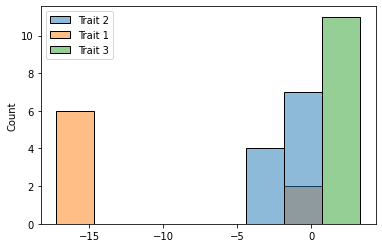

In [19]:
sns.histplot(fig1_wavelets.apply(lambda x: np.log10(x)))


### Load tree

In [20]:
# load tree
fig1_tree = Tree('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/61_otus_unannotated.tree', format=1, quoted_node_names=True)

# relabel leaves and nodes in postorder
c = 22
i = 21
for node in fig1_tree.traverse(strategy='postorder'):
    if node.is_leaf():
        node.name = f'c{c:02}'
        c -= 1
    else:
        node.name = f'i{i:02}'
        i -= 1

In [21]:
def fig1_layout(node, tip_data, wavelet_data, trait):
    '''
    Layout function for tree generated by collapse_to_phylum
    '''
    # print(node.name)
    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    internal_ns['vt_line_width'] = 1
    internal_ns['hz_line_width'] = 1
    
    if node.is_leaf():
        cm = matplotlib.colormaps['gnuplot']
        if tip_data.loc[node.name, trait] != 0:
            c = to_hex(cm(tip_data.loc[node.name, trait]))
        else:
            c = '#808080'
        R1 = RectFace(width=4, height=4, fgcolor=c, bgcolor=c)
        faces.add_face_to_node(R1, node, 0, position='aligned')
    else:
        ''
        t1 = TextFace(node.name)
        faces.add_face_to_node(t1, node, 0)
        # if np.abs(wavelet_data.loc[node.name, trait]) > 1e-15:
        #     internal_ns['size'] = 10
        

    node.img_style = internal_ns

def fig1_ts(**args):
    ts = TreeStyle()
    ts.layout_fn = lambda n: fig1_layout(n, **args)
    # ts.mode = 'c'
    ts.draw_guiding_lines = True
    ts.show_leaf_name = True
    return ts
    

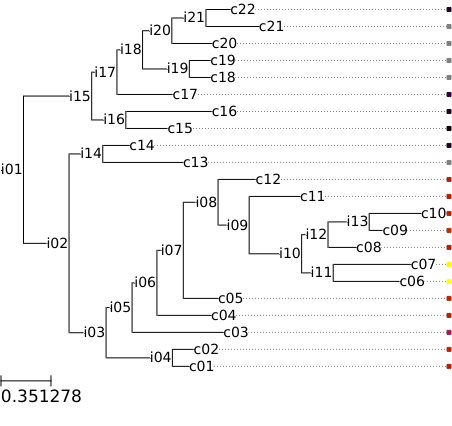

In [22]:
# fig1_tree.render('%%inline', tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 2'), w=500, h=500)
fig1_tree.render('%%inline', tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 2')) #, w=500, h=500)


In [23]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree.svg', 
                            tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 1'), 
                            dpi=400) #  w=500, h=500)

In [82]:
nodes = [n.name for n in fig1_tree.traverse(strategy='postorder') if not n.is_leaf()]
node_postorders = dict((n, i) for n, i in zip(nodes, np.linspace(1, 0, len(nodes))))

leaves = [l.name for l in fig1_tree.traverse(strategy='postorder') if l.is_leaf()]
leaf_postorders = dict((l, i) for l, i in zip(leaves, np.linspace(1, 0, len(leaves))))

In [83]:
def fig1_post_layout(node, n_po, l_po, color=True):
    '''
    Layout function for tree generated by collapse_to_phylum
    '''
    # print(node.name)
    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    # internal_ns['vt_line_width'] = 1
    # internal_ns['hz_line_width'] = 1
    
    cm = matplotlib.colormaps['gnuplot']
    
    if node.is_leaf():
        
        c = to_hex(cm(l_po[node.name]))
        if color:
            R1 = RectFace(width=4, height=4, fgcolor=c, bgcolor=c)
            faces.add_face_to_node(R1, node, 0, position='aligned')
            
        t1 = TextFace(node.name, ftype='Helvetica', fsize=5)
        faces.add_face_to_node(t1, node, 0, position='aligned')
        
    else:
        if color:
            internal_ns['vt_line_color'] = to_hex(cm(n_po[node.name]))
            internal_ns['hz_line_color'] = to_hex(cm(n_po[node.name]))
        
    node.img_style = internal_ns

def fig1_post_ts(**args):
    ts = TreeStyle()
    ts.layout_fn = lambda n: fig1_post_layout(n, **args)
    # ts.mode = 'c'
    ts.draw_guiding_lines = True
    ts.show_leaf_name = False
    ts.branch_vertical_margin = 5
    ts.show_scale = False
    # ts.scale = 500
    ts.force_topology = True
    return ts

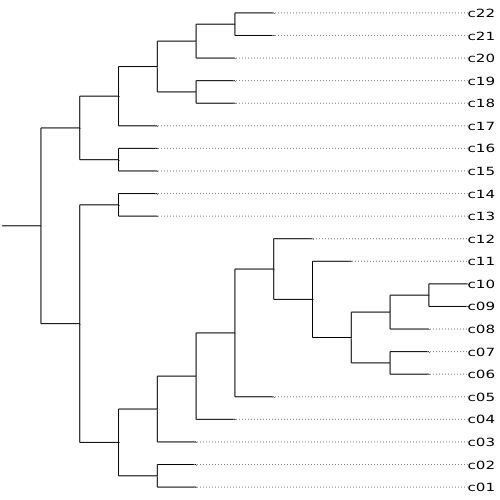

In [84]:
fig1_tree.render('%%inline', tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=False), h=500, w=500)


In [28]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree_nolabel.svg', 
                 tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=False), 
                 h=500, w=500)

In [29]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree_nolabel_colored.svg', 
                 tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=True), 
                 h=500, w=500)

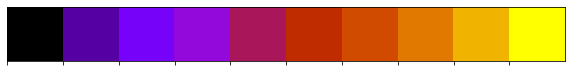

In [30]:
_cmap = cm.gnuplot
sns.palplot([_cmap(i) for i in np.linspace(0,1,10)])


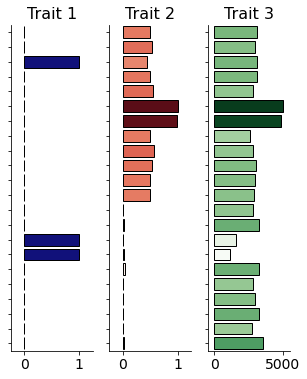

In [32]:
fig = plt.figure(figsize=(5,6))
for color, (i, col) in zip([['white', 'darkblue'], 'Reds', 'Greens'], enumerate(fig1_data.columns)):
    ax = fig.add_subplot(1,3,i+1)
    sns.barplot( y=fig1_data[col].index,
                # x=fig1_data.iloc[::-1][col],
                x=fig1_data[col],
                #s=150, 
                hue=fig1_data.iloc[::-1][col],
                palette=color,
                   linewidth=1,
                   edgecolor='k',
                   legend=False)
    sns.despine()
    ax.set_title(col, fontsize=16)
    plt.tick_params(labelleft=False, labelsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if i ==2:
        ax.set_xlim(-500, 5500)
    else:
        ax.set_xlim(-0.25, 1.25)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_traits.svg', bbox_inches='tight', dpi=400)

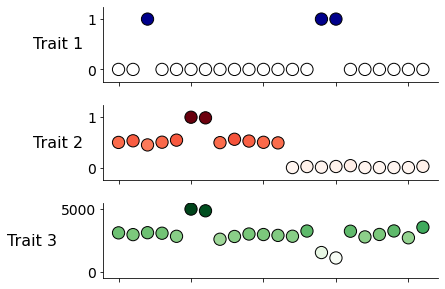

In [33]:
# rotated scatterplot
fig = plt.figure(figsize=(6,5))
for color, (i, col) in zip([['white', 'darkblue'], 'Reds', 'Greens'], enumerate(fig1_data.columns)):
    ax = fig.add_subplot(3,1,i+1)
    sns.scatterplot(x=list(range(len(fig1_data.iloc[::-1][col]))),
                    y=fig1_data.iloc[::-1][col].values,
                # x=fig1_data[col],
                s=150, 
                hue=fig1_data.iloc[::-1][col],
                palette=color,
                   linewidth=1,
                   edgecolor='k',
                   legend=False)
    sns.despine()
    # ax.set_title(col, fontsize=16)
    plt.tick_params(labelbottom=False, labelsize=14)
    ax.set_xlabel('')
    ax.set_ylabel(col, fontsize=16, rotation=0, ha='right', va='center')
    
    if i ==2:
        ax.set_ylim(-500, 5500)
    else:
        ax.set_ylim(-0.25, 1.25)
        
fig.subplots_adjust(hspace=0.3)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_traits_rotated_scatter.svg', 
            bbox_inches='tight', dpi=400)

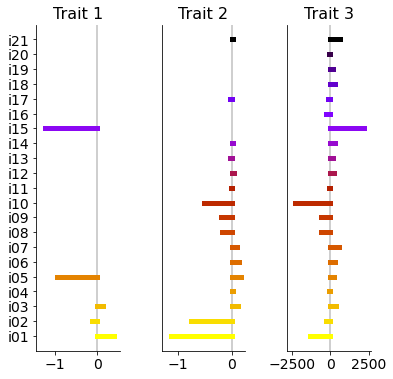

In [73]:
cm = matplotlib.colormaps['gnuplot']

fig = plt.figure(figsize=(6,6))
for i, col in enumerate(fig1_wavelets):
    ax = fig.add_subplot(1,3,i+1)
    for yval, (index, item) in enumerate(fig1_wavelets.iloc[::-1][col].items()):
        plt.plot((0, item), (yval, yval), color=cm(node_postorders[index]), linewidth=5)
    sns.despine()
    ax.set_title(col, fontsize=16)
    plt.tick_params(left=False, labelleft=False, labelsize=14)
    xlims = ax.get_xlim()
    ax.set_xlim(xlims[0]*1.1, xlims[1]*1.1)
    if i == 0:
        ax.set_yticks(range(len(fig1_wavelets.iloc[::-1].index)))
        ax.set_yticklabels(fig1_wavelets.iloc[::-1].index)
        plt.tick_params(left=True, labelleft=True, labelsize=14)
    # if i ==2:
    #     ax.set_xlim(-500, 5500)
    # else:
    #     ax.set_xlim(-0.25, 1.25)
    ax.axvline(0, zorder=0, color='gray', alpha=0.5)
    
fig.subplots_adjust(wspace=0.5)
# plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_wavelets.svg', bbox_inches='tight', dpi=400)

In [93]:
def compute_loc(node, locs):
    if node.is_leaf():
        return locs.loc[node.name]
    else:
        children = node.get_children()
        ly = compute_loc(children[0], locs)
        lr = compute_loc(children[1], locs)
        
        return (ly + lr) / 2


In [95]:
get_leaf_names = lambda node: [l.name for l in node.get_leaves()]

node_xlocs = pd.Series()
for i in fig1_tree.traverse():
    node_xlocs.loc[i.name] = compute_loc(i, pd.Series(leaf_postorders))

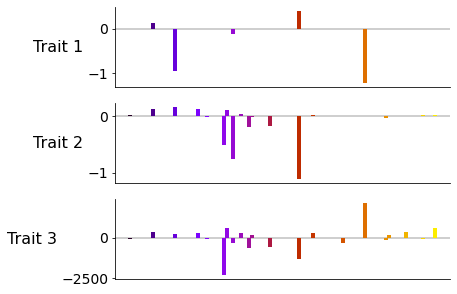

In [103]:
cm = matplotlib.colormaps['gnuplot']

fig = plt.figure(figsize=(6,5))
for i, col in enumerate(fig1_wavelets.sort_index(axis=1)):
    ax = fig.add_subplot(3, 1, i+1)
    for index, item in fig1_wavelets[col].items():
        xval = node_xlocs.loc[index]
        # print(index, xval)
        plt.plot((xval, xval), 
                 (0, item), 
                 color=cm(node_xlocs[index]), 
                 linewidth=4, 
                 solid_capstyle='butt')
    sns.despine()
    ax.set_ylabel(col, ha='right', va='center', fontsize=16, rotation=0)
    plt.tick_params(bottom=False, labelbottom=False, labelsize=14)
    ylims = ax.get_ylim()
    # ax.set_ylim(ylims[0]*1.1, ylims[1]*1.1)
    # if i == 2:
    #     ax.set_xticks(range(len(fig1_wavelets.iloc[::-1].index)))
    #     ax.set_xticklabels(fig1_wavelets.iloc[::-1].index)
    #     plt.tick_params(bottom=True, labelbottom=True, labelsize=14)
    # if i ==2:
    #     ax.set_xlim(-500, 5500)
    # else:
    #     ax.set_xlim(-0.25, 1.25)
    ax.axhline(0, zorder=0, color='gray', alpha=0.5)
    
fig.subplots_adjust(wspace=0.5)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_wavelets_rotated.svg', bbox_inches='tight', dpi=400)

In [77]:
node_xlocs

i01    0.500000
i15    0.166667
i02    0.690476
i17    0.119048
i16    0.309524
i14    0.404762
i03    0.738095
i18    0.095238
c17    0.238095
c16    0.285714
c15    0.333333
c14    0.380952
c13    0.428571
i05    0.690476
i04    0.976190
i20    0.047619
i19    0.166667
i06    0.666667
c03    0.904762
c02    0.952381
c01    1.000000
i21    0.023810
c20    0.095238
c19    0.142857
c18    0.190476
i07    0.642857
c04    0.857143
c22    0.000000
c21    0.047619
i08    0.619048
c05    0.809524
c12    0.476190
i09    0.642857
c11    0.523810
i10    0.666667
i12    0.619048
i11    0.738095
i13    0.595238
c08    0.666667
c07    0.714286
c06    0.761905
c10    0.571429
c09    0.619048
dtype: float64

In [104]:
from sklearn.manifold import TSNE

In [105]:
from scipy.optimize import linear_sum_assignment

In [106]:
def gridify(points, grid_size):
    # Generate random points in x,y space
    np.random.seed(143)  # for reproducibility

    locations = np.array(list(itertools.product(range(grid_size), range(grid_size))))

    # Define the distance function (squared Euclidean distance)
    distance = lambda point, location: np.sum((point - location) ** 2)

    # Initialize the cost matrix
    cost_matrix = np.zeros((len(points), grid_size**2))

    # Populate the cost matrix with distances
    for i, point in enumerate(points):
        for j, location in enumerate(locations):
            cost_matrix[i, j] = distance(point, location)

    # Solve the assignment problem to minimize the total distance
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Assign points to locations based on the optimal solution
    assignments = locations[col_ind].reshape(-1, 2)
    
    return assignments

In [107]:
# ilist = ['i04', 'i05', 'i07', 'c10', 'c11', 'i09', 'i10', 'c17', 'c18', 'c19', 'i17']
ilist = 'i04,c03,c04,c05,i11,i12,c11,c12,i14,i16,i17'.split(',')

In [108]:
i_map = dict((i, [l.name for l in fig1_tree.search_nodes(name=i)[0].get_leaves()]) for i in ilist)

rev_i_map = {}
for key, item in i_map.items():
    for i in item:
        rev_i_map[i] = key

fig1_tsne_data = fig1_data.groupby(rev_i_map).mean()

In [109]:
%%time
tsne_embedding = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3, n_jobs=10).fit_transform(fig1_tsne_data.values)

CPU times: user 12min 8s, sys: 506 ms, total: 12min 9s
Wall time: 24.5 s


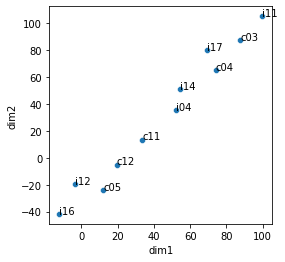

In [110]:
fig, ax = plt.subplots(figsize=(4,4))
tsne_plotdf = pd.DataFrame(tsne_embedding, columns=['dim1', 'dim2'], index=fig1_tsne_data.index)
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2')
for index, row in tsne_plotdf.iterrows():
    ax.annotate(text=index, xy=(row['dim1'], row['dim2']))

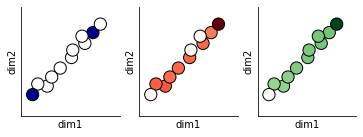

In [142]:
fig = plt.figure(figsize=(6,2))
tsne_plotdf = pd.DataFrame(tsne_embedding, columns=['dim1', 'dim2'], index=fig1_tsne_data.index)
ax = fig.add_subplot(1,3,1)
col = 'Trait 1'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette=['white', 'darkblue'])
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
sns.despine()
ylims = ax.get_ylim()
ax.set_ylim(ylims[0]+(ylims[0]*0.75), ylims[1]*1.25)
xlims = ax.get_xlim()
ax.set_xlim(xlims[0]+(xlims[0]*0.75), xlims[1]*1.25)

ax = fig.add_subplot(1,3,2)
col = 'Trait 2'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette='Reds')
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
sns.despine()
ylims = ax.get_ylim()
ax.set_ylim(ylims[0]+(ylims[0]*0.75), ylims[1]*1.25)
xlims = ax.get_xlim()
ax.set_xlim(xlims[0]+(xlims[0]*0.75), xlims[1]*1.25)

ax = fig.add_subplot(1,3,3)
col = 'Trait 3'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette='Greens')
sns.despine()
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ylims = ax.get_ylim()
ax.set_ylim(ylims[0]+(ylims[0]*0.75), ylims[1]*1.25)
xlims = ax.get_xlim()
ax.set_xlim(xlims[0]+(xlims[0]*0.75), xlims[1]*1.25)

# for index, row in tsne_plotdf.iterrows():
#     ax.annotate(text=index, xy=(row['dim1'], row['dim2']))
plt.savefig('./../figures/group_meeting_figures/fig1_example_layout.svg', bbox_inches='tight')

In [111]:
grid_size = 4
tsne_grid = gridify(tsne_plotdf.values, 4)

In [112]:
tsne_grid_df = pd.DataFrame(tsne_grid, index=tsne_plotdf.index, columns=['dim1', 'dim2'])

In [113]:
grid_spots = np.array(list(itertools.product(np.linspace(tsne_plotdf['dim1'].min(),
                             tsne_plotdf['dim1'].max(),
                             grid_size),
                  np.linspace(tsne_plotdf['dim2'].min(),
                             tsne_plotdf['dim2'].max(),
                             grid_size)))).reshape(grid_size, grid_size, 2)

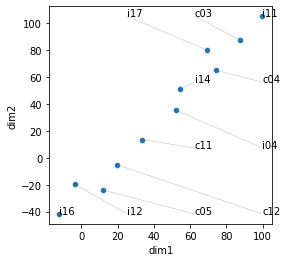

In [114]:
# plot to visualizing snapping
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2')
for index, row in tsne_grid_df.iterrows():
    grid_x, grid_y = grid_spots[tsne_grid_df.loc[index, 'dim1']][tsne_grid_df.loc[index, 'dim2']]
    plt.plot((grid_x, tsne_plotdf.loc[index, 'dim1']),
             (grid_y, tsne_plotdf.loc[index, 'dim2']), color='gray', linewidth=0.25, zorder=0)
    ax.annotate(index, (grid_x, grid_y))
# assignments

In [144]:
tsne_grid_df

,dim1,dim2
c03,2,3
c04,3,2
c05,2,0
c11,2,1
c12,3,0
i04,3,1
i11,3,3
i12,1,0
i14,2,2
i16,0,0


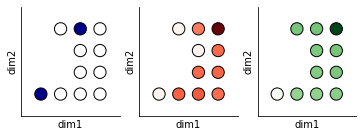

In [152]:
fig = plt.figure(figsize=(6,2))
tsne_plotdf = pd.DataFrame(tsne_embedding, columns=['dim1', 'dim2'], index=fig1_tsne_data.index)
ax = fig.add_subplot(1,3,1)
col = 'Trait 1'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_grid_df, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette=['white', 'darkblue'])
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
sns.despine()
ax.set_ylim(-1, 4)
ax.set_xlim(-1, 4)


ax = fig.add_subplot(1,3,2)
col = 'Trait 2'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_grid_df, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette='Reds')
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
sns.despine()
ax.set_ylim(-1, 4)
ax.set_xlim(-1, 4)

ax = fig.add_subplot(1,3,3)
col = 'Trait 3'
huedict = pd.Series(dict((i, fig1_data.loc[get_leaf_names(fig1_tree.search_nodes(name=i)[0]), col].mean()) for i in ilist))
sns.scatterplot(data=tsne_grid_df, x='dim1', y='dim2', 
                hue=huedict, legend=False, s=150, 
                linewidth=1, edgecolor='k', palette='Greens')
sns.despine()
plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_ylim(-1, 4)
ax.set_xlim(-1, 4)

# for index, row in tsne_plotdf.iterrows():
#     ax.annotate(text=index, xy=(row['dim1'], row['dim2']))
plt.savefig('./../figures/group_meeting_figures/fig1_example_grid_layout.svg', bbox_inches='tight')